In [ ]:
import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

rci = pd.read_csv('stream_app/data/rci.csv')
vip_rate = pd.read_csv('stream_app/data/vip_rate.csv')
visit_rate = pd.read_csv('stream_app/data/visit_rate.csv')
customer_info = pd.read_csv('stream_app/data/customer_info.csv', index_col = 0)

In [ ]:
customer_info['TARGET_RATIO'] = (customer_info['AGE_UNDER5'] / customer_info['FEMALE_20TO40'])\
    .replace(np.nan, 0)

customer_info.drop(columns = ['AGE_UNDER5', 'FEMALE_20TO40'], inplace= True)
original_data = customer_info[['AVG_ASSET_3MO', 'TOT_SALES_3MO', 'TARGET_RATIO']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(original_data)

c:\Users\User\anaconda3\envs\dx_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



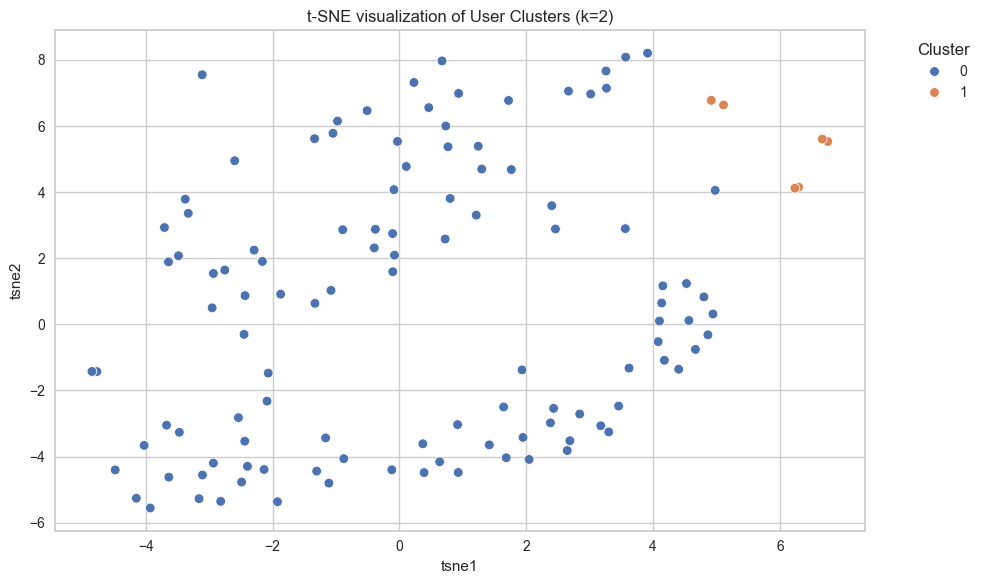

c:\Users\User\anaconda3\envs\dx_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



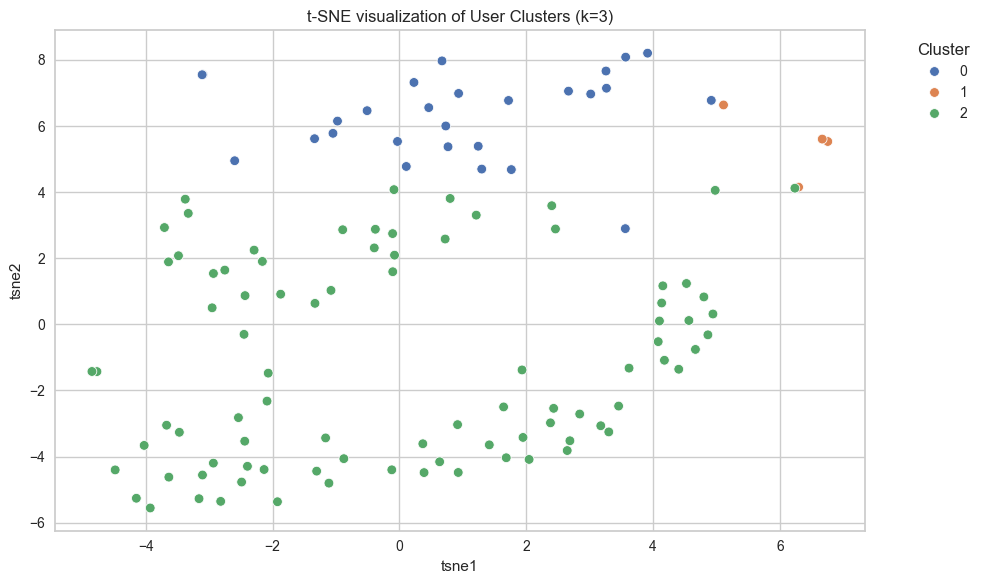

c:\Users\User\anaconda3\envs\dx_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



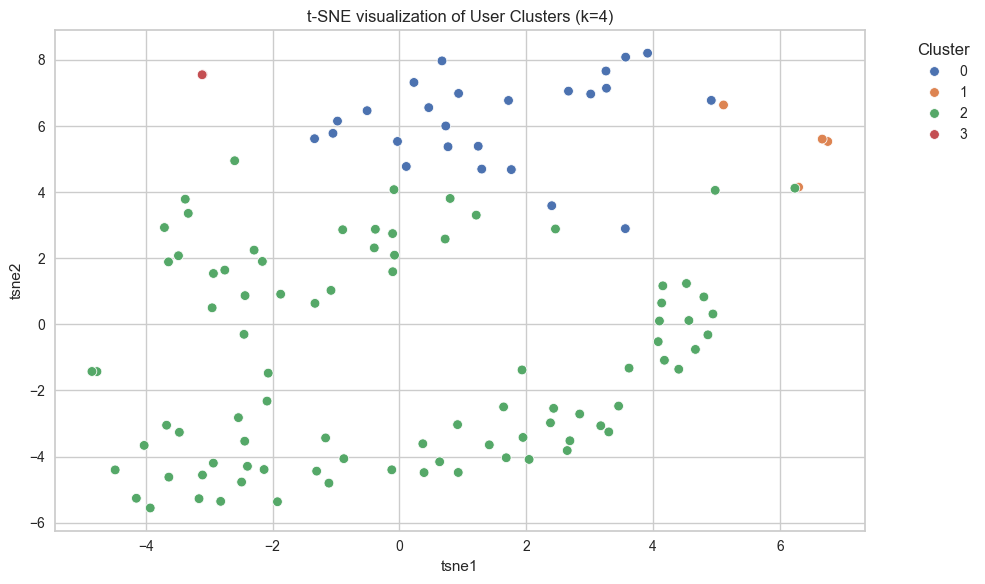

c:\Users\User\anaconda3\envs\dx_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



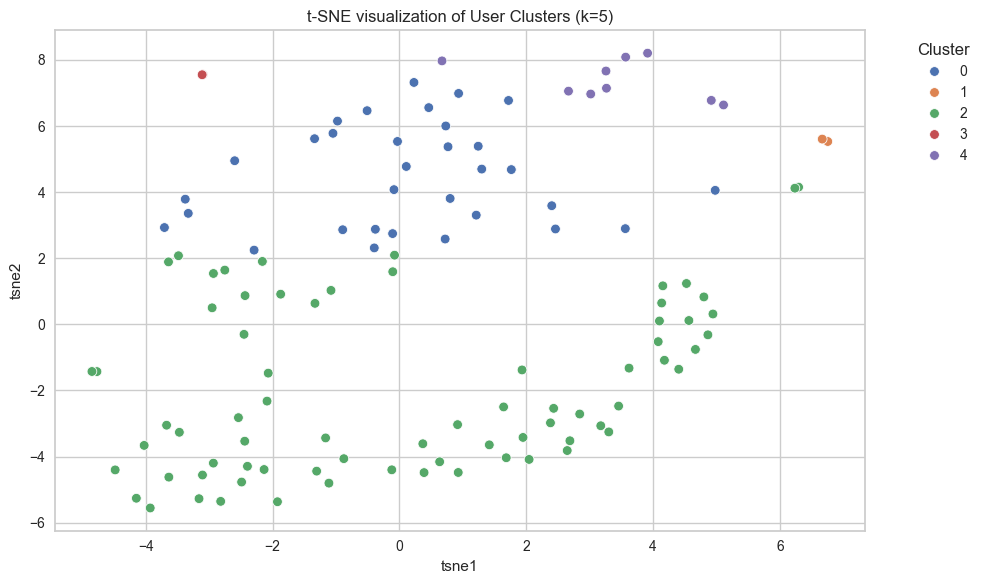

c:\Users\User\anaconda3\envs\dx_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



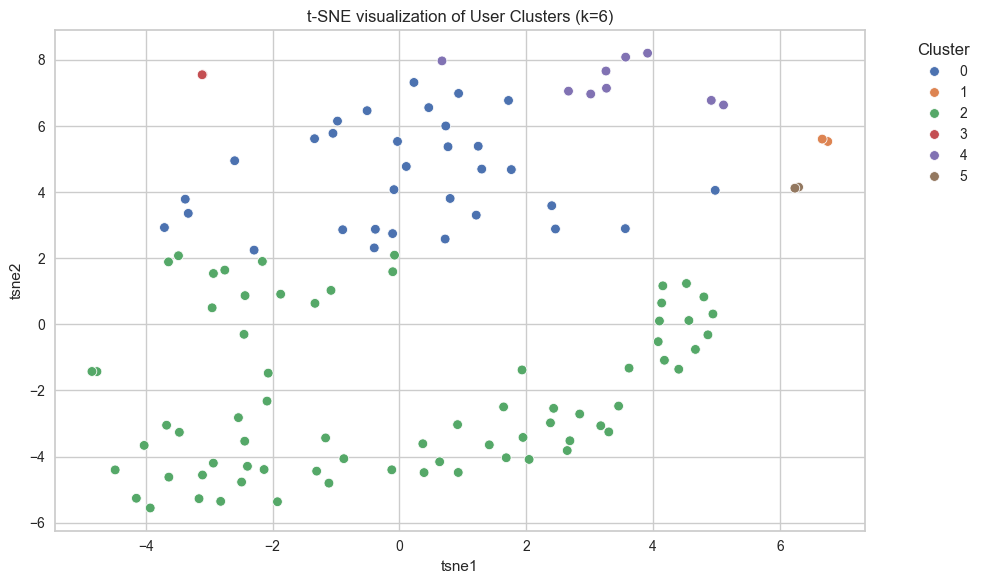

c:\Users\User\anaconda3\envs\dx_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



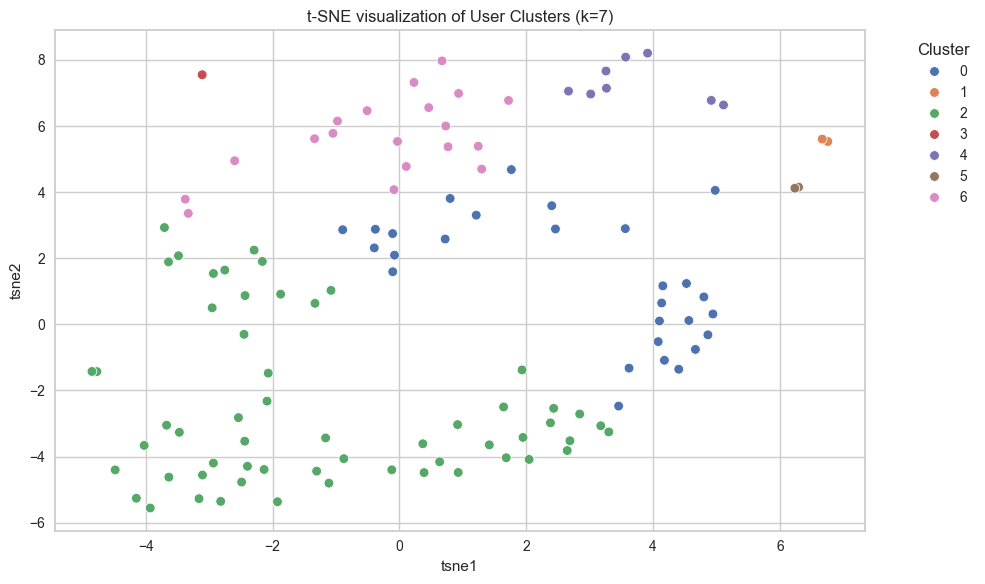

c:\Users\User\anaconda3\envs\dx_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



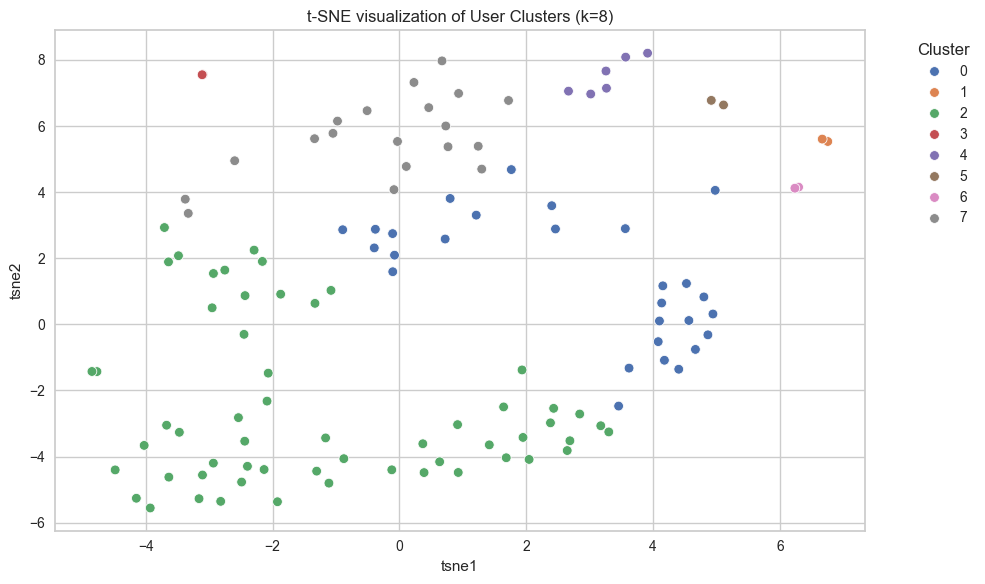

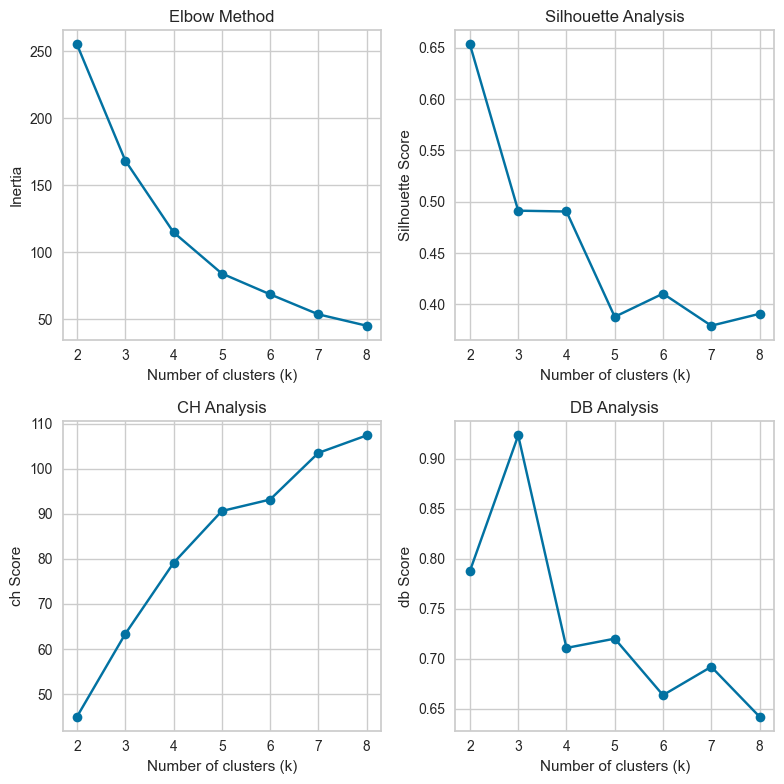

In [132]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm

def hdbscanner(data):
    results = []
    min_cluster_sizes = [x for x in range(2, 8)]
    perplexities = [5, 10, 20, 30, 40, 50]
    for p in tqdm(perplexities, desc = "HDBScanning"):
        tsne = TSNE(n_components=2, perplexity= p, random_state= 42)
        tsne_results = tsne.fit_transform(data)
        for c in min_cluster_sizes:
            cluster = hdbscan.HDBSCAN(min_cluster_size= c, prediction_data= True)
            cluster_labels = cluster.fit_predict(data)
            probs = cluster.probabilities_
            sil_score = silhouette_score(tsne_results, cluster_labels)
            confidence = np.mean(probs)
            results.append({
                'perplexity': p,
                'min_cluster_size': c,
                'n_clusters': len(set(cluster_labels)),
                'silhouette_score': sil_score,
                'labels' : cluster_labels,
                'mean_confidence': confidence
                })
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values(by='mean_confidence', ascending=False)
    display(results_df.head())
    tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne1', 'tsne2'])
    tsne_df['cluster'] = results_df['labels'][0]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cluster', palette='deep')
    plt.title(f't-SNE visualization of User Clusters')
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def kmeansclt(data, start, end):
    tsne = TSNE(n_components=2, random_state= 42)
    tsne_results = tsne.fit_transform(data)
    tsne_df = pd.DataFrame(data=tsne_results, columns=['tsne1', 'tsne2'])

    inertias = []
    sil_scores = []
    ch_scores = []
    db_scores = []
    clusters = []
    for k in range(start, end + 1):
        kmeans_optimal = KMeans(n_clusters= k, random_state=42)
        cluster = kmeans_optimal.fit_predict(data)
        inertia = kmeans_optimal.inertia_
        sil_score = silhouette_score(data , cluster)
        ch_score = calinski_harabasz_score(data, cluster)
        db_score = davies_bouldin_score(data, cluster)
        inertias.append(inertia)
        sil_scores.append(sil_score)
        ch_scores.append(ch_score)
        db_scores.append(db_score)
        clusters.append(cluster)
        tsne_df['cluster'] = cluster
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=tsne_df, x='tsne1', y='tsne2', hue='cluster', palette='deep')
        plt.title(f't-SNE visualization of User Clusters (k={k})')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
    # 엘보우 방법 시각화
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.plot(range(2, len(inertias) + 2), inertias, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')
    
    # 실루엣 점수 시각화
    plt.subplot(2, 2, 2)
    plt.plot(range(2, len(sil_scores) + 2), sil_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Analysis')

    plt.subplot(2, 2, 3)
    plt.plot(range(2, len(ch_scores) + 2), ch_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('ch Score')
    plt.title('CH Analysis')

    plt.subplot(2, 2, 4)
    plt.plot(range(2, len(db_scores) + 2), db_scores, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('db Score')
    plt.title('DB Analysis')
    
    plt.tight_layout()
    plt.show()
    return clusters

    
# hdbscanner(scaled_data)
clusters = kmeansclt(scaled_data, 2, 8)

In [ ]:
customer_info['cluster'] = clusters[1]

customer_info.rename(columns={
    "CITY_KOR_NAME": "시군구",
    "DISTRICT_KOR_NAME": "읍면동",
    "AVG_ASSET_3MO": "3개월_평균자산",
    "TOT_SALES_3MO": "3개월_평균카드매출",
    "TARGET_RATIO": "타겟_고객군_비율 (아이가 있는 20~40대 여성)",
    "cluster": "클러스터"
}, inplace=True)

def format_won(x, unit):
    raw = x * unit
    if raw >= 100000000:
        return f"{raw / 100000000:.1f}억 원"
    elif raw >= 10000:
        return f"{raw / 10000:.1f}만 원"
    else:
        return f"{int(raw):,} 원"

cluster_name_map = {
    0: "타깃 소비지 중심지",
    1: "고매출 상권",
    2: "일반 주거지역"
}

customer_info["3개월_평균자산"] = customer_info["3개월_평균자산"].apply(lambda x : format_won(x, 10000))
customer_info["3개월_평균카드매출"] = customer_info["3개월_평균카드매출"].apply(lambda x : format_won(x, 1))
customer_info["타겟_고객군_비율 (아이가 있는 20~40대 여성)"] = customer_info["타겟_고객군_비율 (아이가 있는 20~40대 여성)"].apply(lambda x: f"{x * 100:.2f}%")
customer_info["클러스터"] = customer_info["클러스터"].map(cluster_name_map)

customer_info.head()
customer_info.to_csv('./stream_app/data/customer_info.csv', index=False)

In [ ]:
rci['STANDARD_YEAR_MONTH'] = rci['STANDARD_YEAR_MONTH'].astype(str).str[:4] + '-' +\
      rci['STANDARD_YEAR_MONTH'].astype(str).str[4:]

rci.to_csv('C:/Users/User/Downloads/snowflake/data/RCI.csv')

In [177]:
from sklearn.preprocessing import MinMaxScaler

temp_df = pd.merge(rci, visit_rate, left_on=['STANDARD_YEAR_MONTH', 'DEP_NAME', 'ADDR_LV2', 'ADDR_LV3'],\
                   right_on=['YM_DATE', 'DEP_NAME', 'ADDR_LV2', 'ADDR_LV3'], how='inner')

merge_df = pd.merge(temp_df, vip_rate, on= ['DEP_NAME', 'ADDR_LV2', 'ADDR_LV3'], how='inner')

merge_df.drop(columns=['YM_DATE', 'ADDR_LV1'], inplace= True)

merge_df['sales_log'] = np.log1p(merge_df['SALES_ADDR'])
merge_df['visitors_log'] = np.log1p(merge_df['REGION_VISIT'])
merge_df['vip_log'] = np.log1p(merge_df['VIP_RATE'])

sales_scaled = MinMaxScaler().fit_transform(merge_df[['sales_log']])
VIP_scaled = MinMaxScaler().fit_transform(merge_df[['vip_log']])
Traffic_scaled = MinMaxScaler().fit_transform(merge_df[['visitors_log']])

merge_df['COVERAGE_SCORE'] = (
    0.4 * sales_scaled +
    0.3 * VIP_scaled +
    0.3 * Traffic_scaled
)

merge_df.drop(columns=['sales_log', 'visitors_log', 'vip_log'], inplace = True)

merge_df.to_csv('./data/metric.csv')

In [248]:
region = pd.read_csv('./stream_app/data/region.csv')
region_df = region[['CITY_KOR_NAME', 'DISTRICT_KOR_NAME', 'DISTRICT_GEOM']]
merge_df_w_district = pd.merge(merge_df, region_df, left_on = ['ADDR_LV2','ADDR_LV3'], right_on = ['CITY_KOR_NAME', 'DISTRICT_KOR_NAME'])
merge_df_w_district.drop(columns= ['CITY_KOR_NAME', 'DISTRICT_KOR_NAME'], inplace = True)
merge_df_w_district.to_csv('./stream_app/data/metric.csv')

In [395]:
region = pd.read_csv('./stream_app/data/region.csv')
rci = pd.read_csv('./stream_app/data/RCI.csv', index_col = 0)

region_df = region[['CITY_KOR_NAME', 'DISTRICT_KOR_NAME', 'DISTRICT_GEOM']]
merge_df_w_rci = pd.merge(rci, region_df, left_on = ['ADDR_LV2','ADDR_LV3'], right_on = ['CITY_KOR_NAME', 'DISTRICT_KOR_NAME'])
merge_df_w_rci.drop(columns= ['CITY_KOR_NAME', 'DISTRICT_KOR_NAME'], inplace = True)
merge_df_w_rci.to_csv('./stream_app/data/RCI.csv')